In [1]:
# Imports
import random
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
model_name = 'smard_predictions'

In [3]:
# Loading test data
test = pd.read_csv('../../Data/Raw/test/raw.csv')
test['Date'] = pd.to_datetime(test['Date'], dayfirst=True)

test.tail()

,Date,Time,Datetime,50Hertz,Amprion,TenneT,TransnetBW,Total,Delta
26199,2023-09-30,22:45,2023-09-30 22:45:00,2232.50,3605.25,3119.75,1211.75,10169.00,0.25
26200,2023-09-30,23:00,2023-09-30 23:00:00,2179.00,3544.75,3096.75,1203.50,10024.00,0.00
26201,2023-09-30,23:15,2023-09-30 23:15:00,2174.75,3456.50,3101.00,1184.50,9916.50,0.25
26202,2023-09-30,23:30,2023-09-30 23:30:00,2119.00,3385.50,3044.75,1173.50,9722.75,0.00
26203,2023-09-30,23:45,2023-09-30 23:45:00,2092.00,3341.75,3003.25,1156.75,9594.00,0.25


In [4]:
# Loading smard prediction data
smard = pd.read_csv('../../Data/Raw/smard_preds/raw.csv')
smard['Date'] = pd.to_datetime(smard['Date'], dayfirst=True)

# Handle missing data
for column in ['50Hertz', 'Amprion', 'TenneT', 'TransnetBW', 'Total', 'Delta']:
    mean_value = smard[column][smard[column] != 0].mean()

    smard[column] = smard[column].apply(lambda x: mean_value if x == 0 else x)

smard.tail()

,Date,Time,Datetime,50Hertz,Amprion,TenneT,TransnetBW,Total,Delta
26199,2023-09-30,22:45,2023-09-30 22:45:00,2216.25,3544.50,2620.00,1314.50,9695.25,230.553966
26200,2023-09-30,23:00,2023-09-30 23:00:00,2167.75,3456.25,2584.50,1267.00,9475.50,230.553966
26201,2023-09-30,23:15,2023-09-30 23:15:00,2138.75,3393.50,2549.50,1243.75,9325.25,0.250000
26202,2023-09-30,23:30,2023-09-30 23:30:00,2113.50,3328.25,2511.00,1224.75,9177.50,230.553966
26203,2023-09-30,23:45,2023-09-30 23:45:00,2092.00,3261.25,2459.75,1219.00,9032.00,230.553966


In [5]:
# Performance calculation
def performance_check(y, y_hat):
    raw_mape = mean_absolute_percentage_error(y, y_hat)
    raw_sdmae = mean_absolute_error(y, y_hat) / np.std(y)
    return raw_mape, raw_sdmae

# Perfromance evaluation
def performance_evaluation(n_iter, n_days):
    metrics = []
    start_date = datetime(2023, 1, 31)
    end_date = datetime(2023, 7, 31)
    date_range = (end_date - start_date).days - n_days
    
    for i in range(n_iter):
        random_days_offset = random.randint(0, date_range)
        random_start_date = start_date + timedelta(days=random_days_offset)
        random_end_date = random_start_date + timedelta(days=n_days)

        pred_df = smard.loc[(smard['Date'] >= random_start_date) & (smard['Date'] <= random_end_date)]
        test_df = test.loc[(test['Date'] >= random_start_date) & (test['Date'] <= random_end_date)]

        for n in ['50Hertz', 'Amprion',	'TenneT', 'TransnetBW', 'Total', 'Delta']:
            mape, sdmae = performance_check(test_df[n], pred_df[n])
            metrics.append((n, mape, sdmae))
    
    metrics_df = pd.DataFrame(metrics, columns=['control_area', 'mape', 'sdmae'])
    grouped_df = metrics_df.groupby('control_area').agg({'mape': 'mean', 'sdmae': 'mean'}).reset_index()
    output_df = grouped_df.rename(columns={'mape': 'avg_mape', 'sdmae': 'avg_sdmae'})
        
    return output_df

# Metric formatting for plotting
def metric_formatting(raw_mape, raw_sdmae):
    if raw_mape < 1:
        mape = f'{round(raw_mape*100, 2)}%'
    else:
        mape = 'too high'
    if raw_sdmae < 1:
        sdmae = round(raw_sdmae, 4)
    else:
        sdmae = 'too high'
    return mape, sdmae

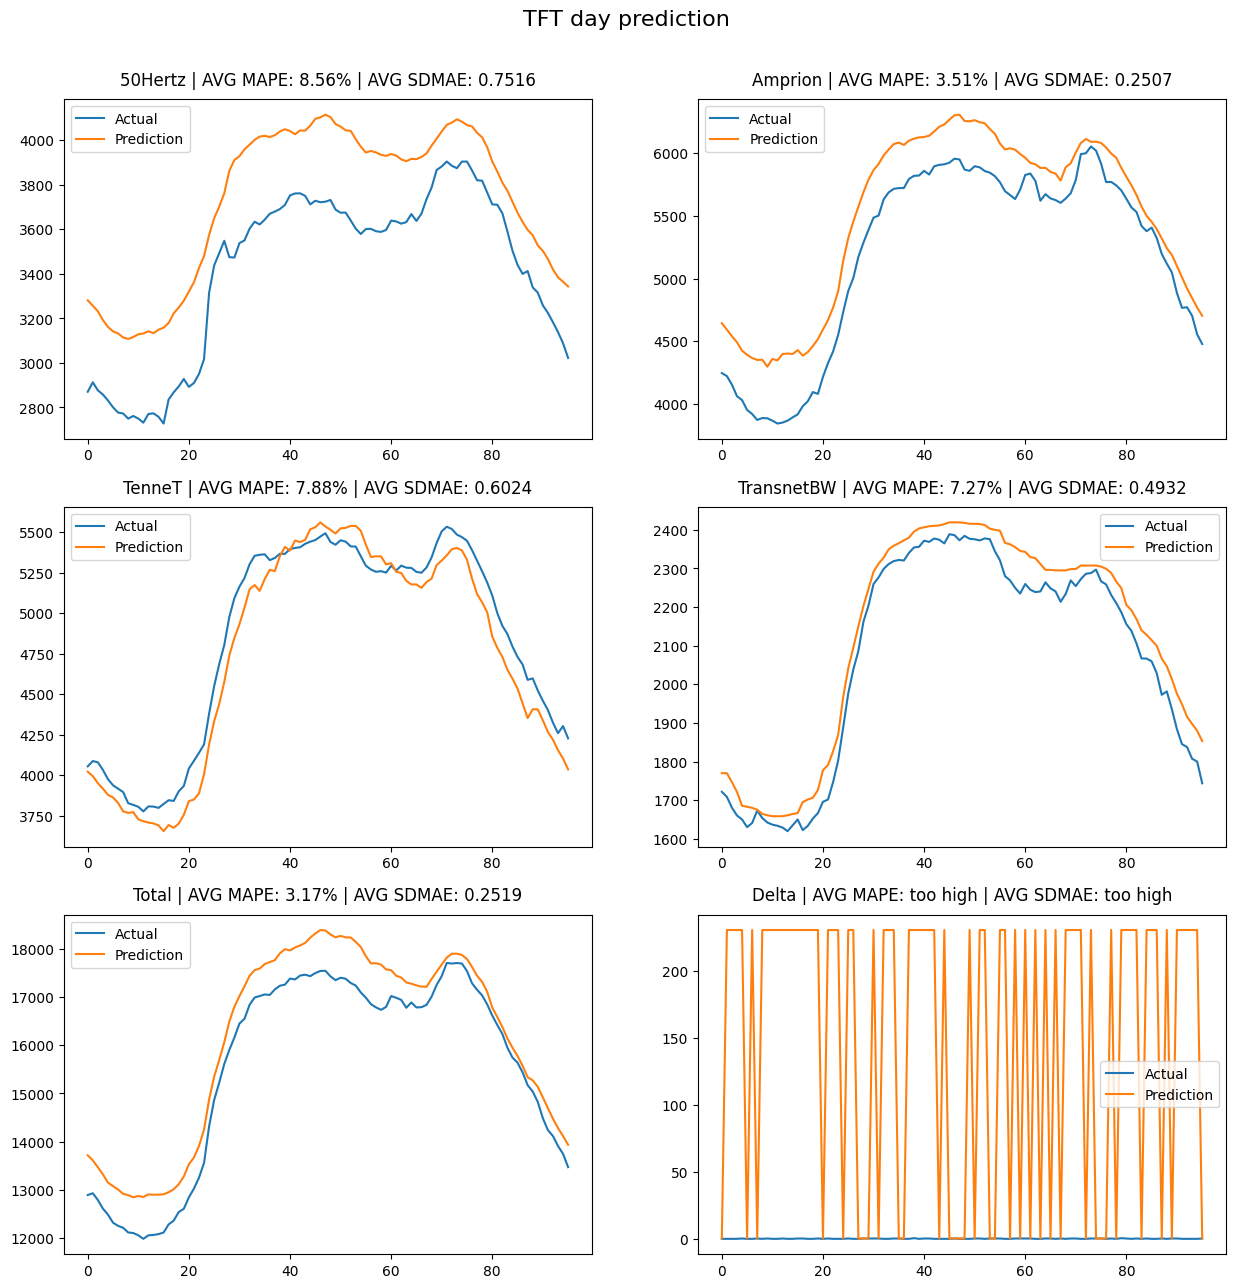

In [6]:
# Plotting predictions against test data
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

# Set test interval
start_date = pd.to_datetime('01.02.2023', dayfirst=True)
end_date = pd.to_datetime('02.02.2023', dayfirst=True)

# Get predictions and actuals
pred_df = smard.loc[(smard['Date'] >= start_date) & (smard['Date'] < end_date)]
test_df = test.loc[(test['Date'] >= start_date) & (test['Date'] < end_date)]

fig.suptitle('TFT day prediction', fontsize=16, y=0.94)

for i in range(3):
    for j in range(2):
        control_area = ['50Hertz', 'Amprion', 'TenneT', 'TransnetBW', 'Total', 'Delta'][i * 2 + j]

        pred_data = pred_df[control_area]
        actual_data = test_df[control_area]

        metric_df = performance_evaluation(100, 1)
        mape, sdmae = metric_formatting(metric_df.loc[metric_df['control_area'] == control_area, 'avg_mape'].values[0],
                                        metric_df.loc[metric_df['control_area'] == control_area, 'avg_sdmae'].values[0])

        ax[i][j].plot(actual_data.reset_index(drop=True), label='Actual')
        ax[i][j].plot(pred_data.reset_index(drop=True), label='Prediction')
        ax[i][j].set_title(control_area)
        ax[i][j].set_title(f'{control_area} | AVG MAPE: {mape} | AVG SDMAE: {sdmae}', loc="center", pad=10)
        ax[i][j].legend()

plt.savefig(f'{model_name}_day_prediction.svg', format='svg')

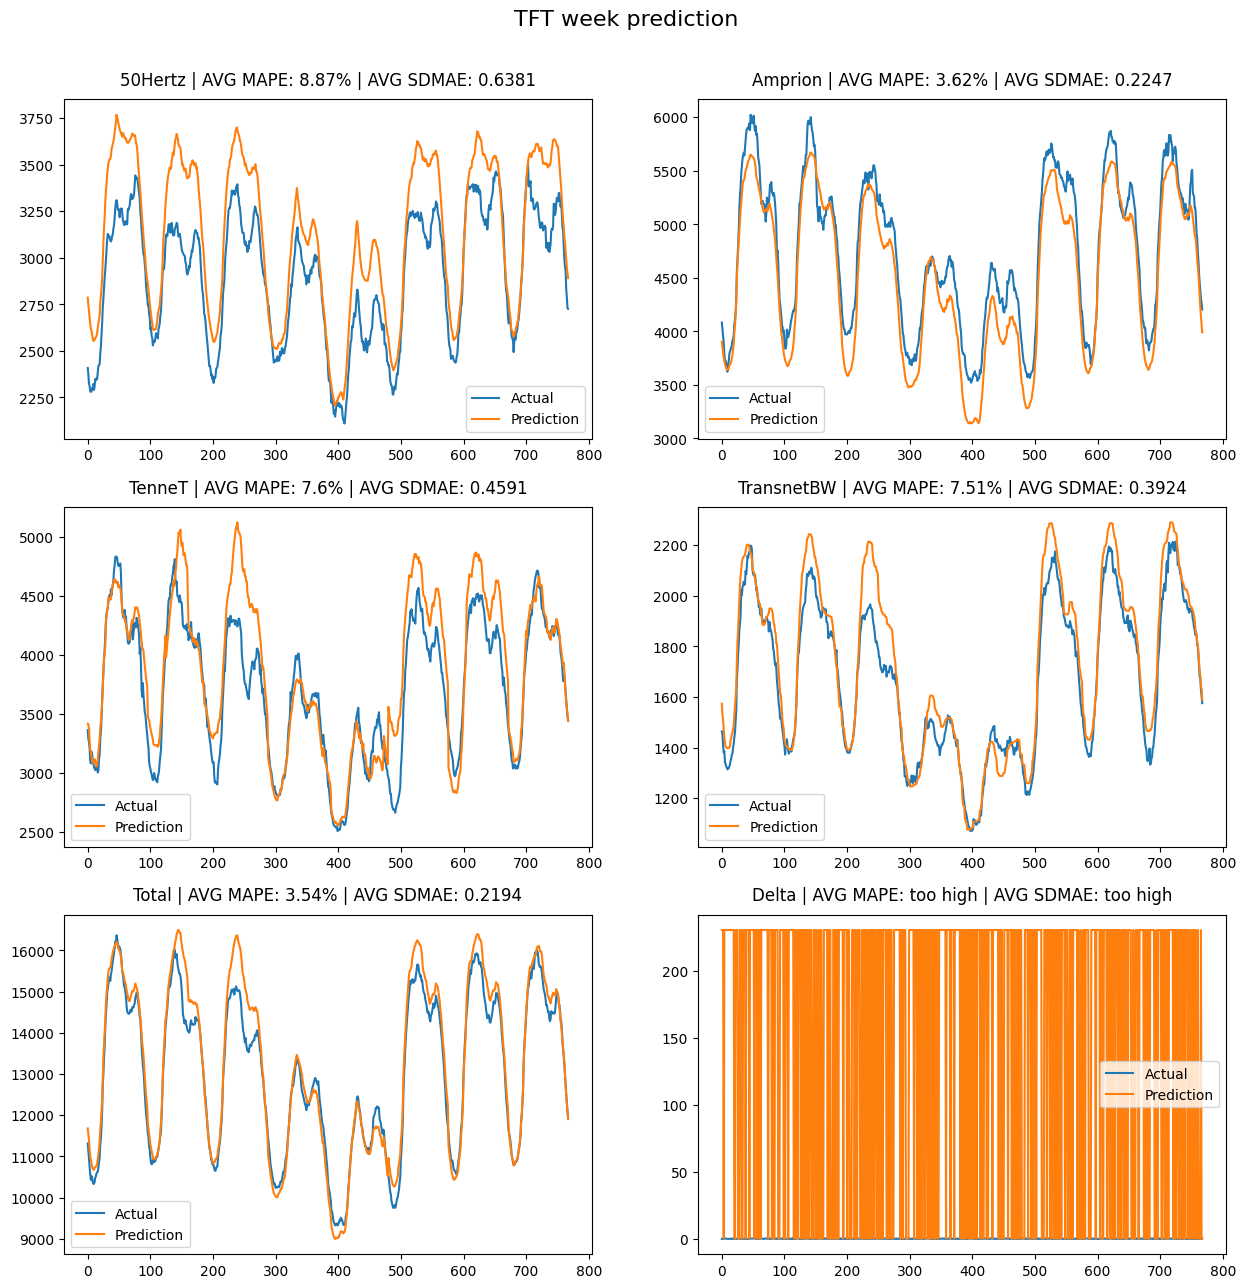

In [7]:
# Plotting predictions against test data
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

# Set test interval
start_date = pd.to_datetime('12.04.2023', dayfirst=True)
end_date = pd.to_datetime('20.04.2023', dayfirst=True)

# Get predictions and actuals
pred_df = smard.loc[(smard['Date'] >= start_date) & (smard['Date'] < end_date)]
test_df = test.loc[(test['Date'] >= start_date) & (test['Date'] < end_date)]

fig.suptitle('TFT week prediction', fontsize=16, y=0.94)

for i in range(3):
    for j in range(2):
        control_area = ['50Hertz', 'Amprion', 'TenneT', 'TransnetBW', 'Total', 'Delta'][i * 2 + j]

        pred_data = pred_df[control_area]
        actual_data = test_df[control_area]

        metric_df = performance_evaluation(100, 7)
        mape, sdmae = metric_formatting(metric_df.loc[metric_df['control_area'] == control_area, 'avg_mape'].values[0],
                                        metric_df.loc[metric_df['control_area'] == control_area, 'avg_sdmae'].values[0])

        ax[i][j].plot(actual_data.reset_index(drop=True), label='Actual')
        ax[i][j].plot(pred_data.reset_index(drop=True), label='Prediction')
        ax[i][j].set_title(control_area)
        ax[i][j].set_title(f'{control_area} | AVG MAPE: {mape} | AVG SDMAE: {sdmae}', loc="center", pad=10)
        ax[i][j].legend()

plt.savefig(f'{model_name}_week_prediction.svg', format='svg')

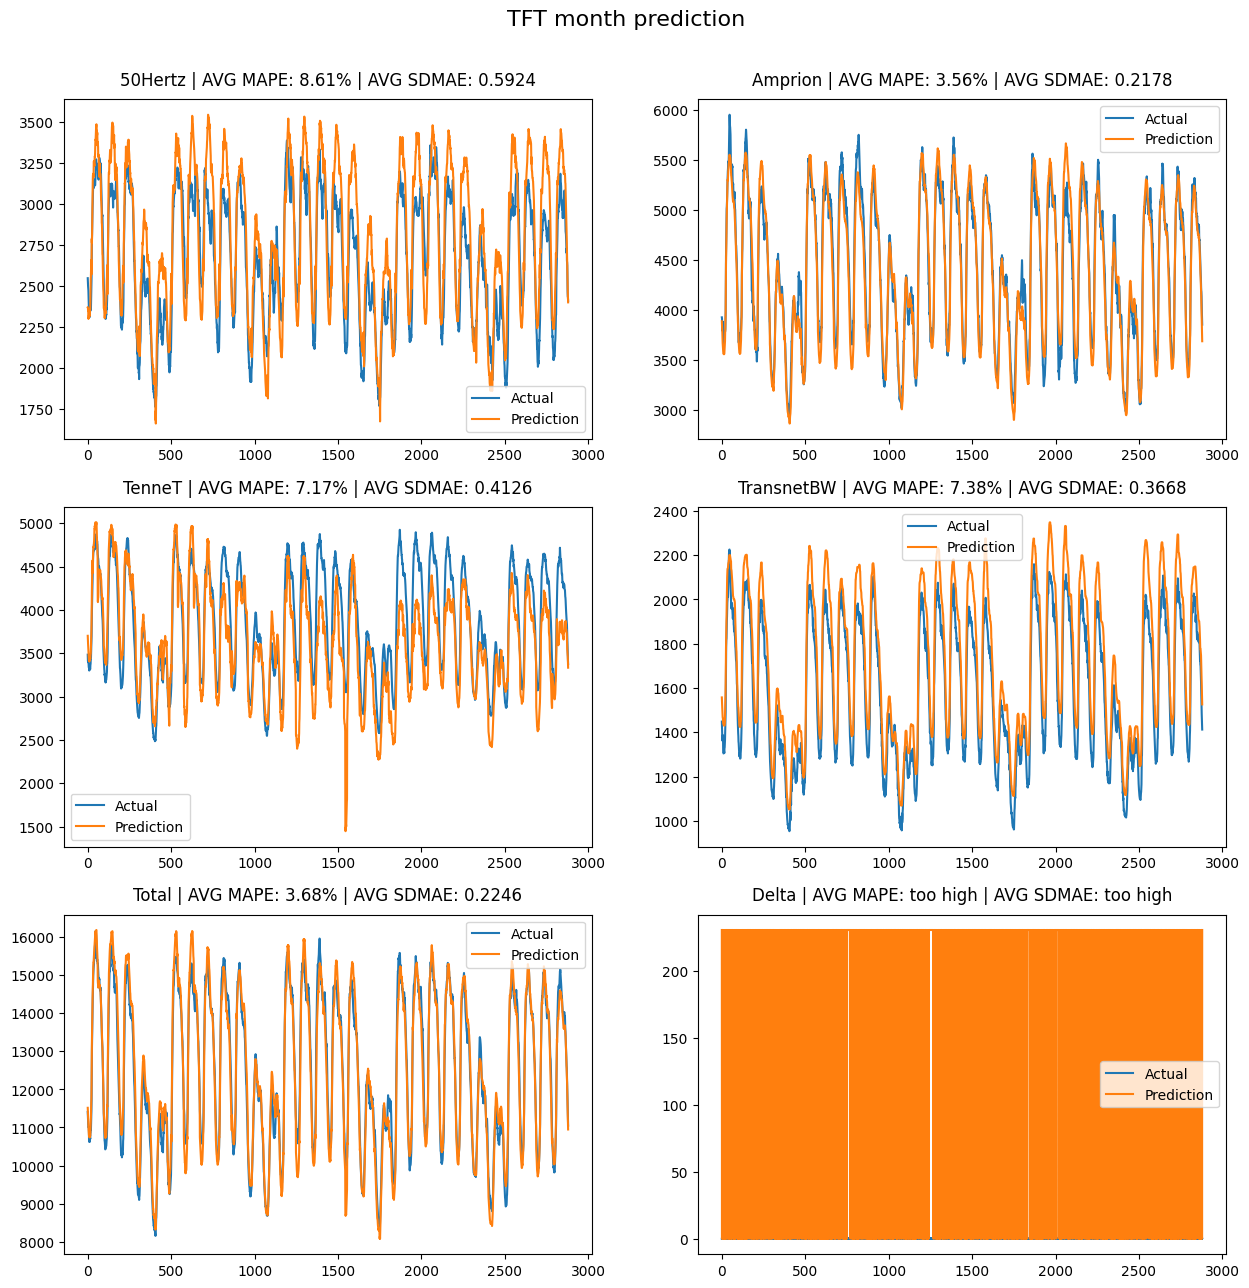

In [8]:
# Plotting predictions against test data
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

# Set test interval
start_date = pd.to_datetime('21.06.2023', dayfirst=True)
end_date = pd.to_datetime('21.07.2023', dayfirst=True)

# Get predictions and actuals
pred_df = smard.loc[(smard['Date'] >= start_date) & (smard['Date'] < end_date)]
test_df = test.loc[(test['Date'] >= start_date) & (test['Date'] < end_date)]

fig.suptitle('TFT month prediction', fontsize=16, y=0.94)

for i in range(3):
    for j in range(2):
        control_area = ['50Hertz', 'Amprion', 'TenneT', 'TransnetBW', 'Total', 'Delta'][i * 2 + j]

        pred_data = pred_df[control_area]
        actual_data = test_df[control_area]

        metric_df = performance_evaluation(100, 30)
        mape, sdmae = metric_formatting(metric_df.loc[metric_df['control_area'] == control_area, 'avg_mape'].values[0],
                                        metric_df.loc[metric_df['control_area'] == control_area, 'avg_sdmae'].values[0])

        ax[i][j].plot(actual_data.reset_index(drop=True), label='Actual')
        ax[i][j].plot(pred_data.reset_index(drop=True), label='Prediction')
        ax[i][j].set_title(control_area)
        ax[i][j].set_title(f'{control_area} | AVG MAPE: {mape} | AVG SDMAE: {sdmae}', loc="center", pad=10)
        ax[i][j].legend()

plt.savefig(f'{model_name}_month_prediction.svg', format='svg')

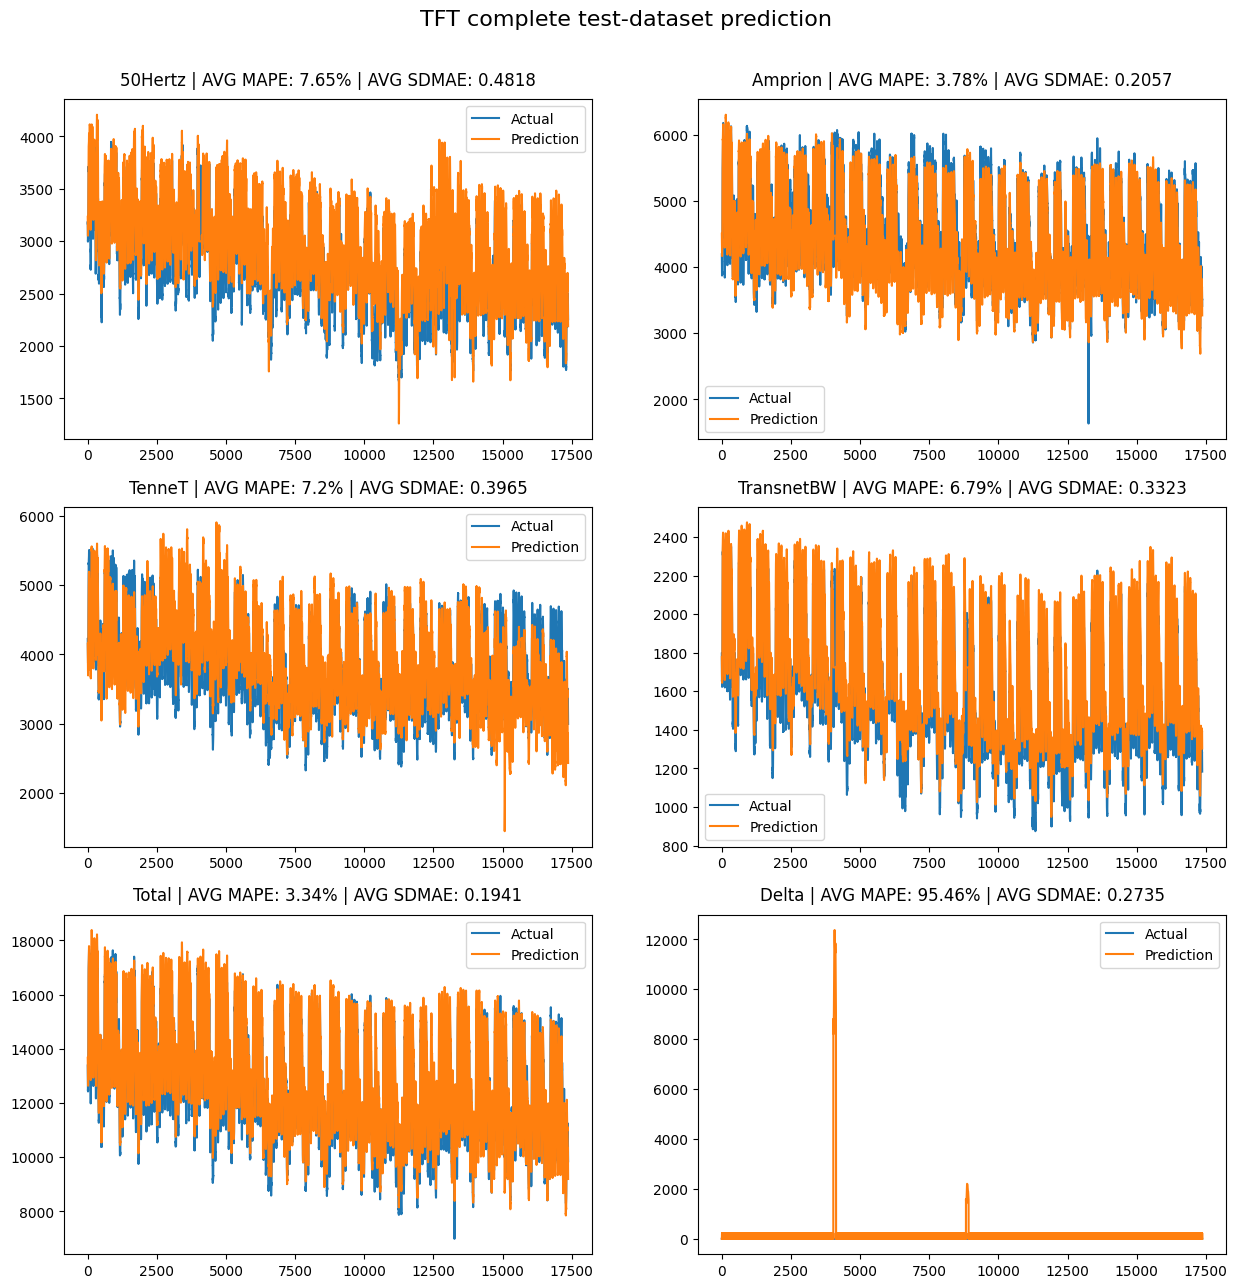

In [9]:
# Plotting predictions against test data
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

# Set test interval
start_date = pd.to_datetime('31.01.2023', dayfirst=True)
end_date = pd.to_datetime('31.07.2023', dayfirst=True)

# Get predictions and actuals
pred_df = smard.loc[(smard['Date'] >= start_date) & (smard['Date'] < end_date)]
test_df = test.loc[(test['Date'] >= start_date) & (test['Date'] < end_date)]

fig.suptitle('TFT complete test-dataset prediction', fontsize=16, y=0.94)

for i in range(3):
    for j in range(2):
        control_area = ['50Hertz', 'Amprion', 'TenneT', 'TransnetBW', 'Total', 'Delta'][i * 2 + j]

        pred_data = pred_df[control_area]
        actual_data = test_df[control_area]

        mape, sdmae = metric_formatting(*performance_check(pred_data, actual_data))

        ax[i][j].plot(actual_data.reset_index(drop=True), label='Actual')
        ax[i][j].plot(pred_data.reset_index(drop=True), label='Prediction')
        ax[i][j].set_title(control_area)
        ax[i][j].set_title(f'{control_area} | AVG MAPE: {mape} | AVG SDMAE: {sdmae}', loc="center", pad=10)
        ax[i][j].legend()

plt.savefig(f'{model_name}_complete_prediction.svg', format='svg')